# Machine Learning Engineer Nanodegree

## Predict which products will an Instacart consumer purchase again


### Project Navigation:

- <a href="#definition">Definition</a>
- <a href="#analysis">Analysis</a>
- <a href="#methodology">Methodology</a>
- <a href="#results">Results</a>
- <a href="#conclusion">Conclusion</a>

## Definition <a id="definition"></a>

### Project Overview

Instacart is an online grocery delivery service provider. The main objective of this project is to use data on customer orders over time to predict which previously purchased products will be in a user’s next order.

The dataset consists of relational set of files describing customer’s orders over time. The dataset is anonymised and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user there is between 4 and 100 of their orders, with the sequence of products purchased in each order.

The entity that are provided includes:

- Aisles
- Departments
- Order_Products_Prior
- Order_Products_Train
- Orders
- Products

### Problem Statement

Same day delivery service for online orders are becoming more common, in order to meet the consumer demand there is a need for better understanding of:
- Where the customer are located
- From which store orders are being placed
- What items are being bought
- How many items are repeated in subsequent orders
- Frequency of orders

Original input dataset is transformed to correlate relationship between product and consumer’s buying pattern. This transformed dataset is used as input to our model.

Inputs to our model will be feature dataset extracted along with label specifying whether product is reordered or not - thus this can be seen as classification problem having 2 labels and output tells probability of product being ordered again for future orders.

### Metrics

Since our dataset is not balanced we will be using F-Score as evaluation metrics, F score is the Harmonic mean between precision and recall. The greater the F score, the better is the performance of our model, which is defines as follows:


`F = ((1+beta**2)*TruePositive) / (((1+beta**2)*TruePositive) + beta**2*FalseNegative+FalsePositive)`

Where,
```
True Positive = correctly predicted the product in next order
True Negatives = correctly predicted the product not in next order
False Positive = wrongly predicted the product in next order
False Negative = failed to predict the product in next order
```

## Analysis <a id="analysis"></a>

### Importing necessary library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

%matplotlib inline

### Load all data files

In [2]:
df_aisles = pd.read_csv('dataset/aisles.csv')
df_departments = pd.read_csv('dataset/departments.csv')
df_order_products_prior = pd.read_csv('dataset/order_products__prior.csv')
df_order_products_train = pd.read_csv('dataset/order_products__train.csv')
df_orders = pd.read_csv('dataset/orders.csv')
df_products = pd.read_csv('dataset/products.csv')

### Data Exploration

#### Sampling of the data, check for duplicates & missing fields

### Aisles

In [3]:
df_aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
df_aisles.shape

(134, 2)

In [5]:
sum(df_aisles.duplicated())

0

In [6]:
df_aisles.isnull().sum()

aisle_id    0
aisle       0
dtype: int64

Contains no duplicates and missing values, and has total of 134 aisles which are being used in products entity representing where respective product is placed.

### Departments

In [7]:
df_departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
df_departments.shape

(21, 2)

In [9]:
sum(df_departments.duplicated())

0

In [10]:
df_departments.isnull().sum()

department_id    0
department       0
dtype: int64

Contains no duplicates and missing values, and has total of 21 departments which are being used in products entity representing how products are grouped based on their properties.

### order_products_prior

In [11]:
df_order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [12]:
df_order_products_prior.shape

(32434489, 4)

In [13]:
sum(df_order_products_prior.duplicated())

0

In [14]:
df_order_products_prior.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

Constains products in each order (which are marked prior in **eval_set**)

### order_products_train

In [15]:
df_order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [16]:
df_order_products_train.shape

(1384617, 4)

In [17]:
sum(df_order_products_train.duplicated())

0

In [18]:
df_order_products_train.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

Constains products in each order (which are marked train in **eval_set**)

### Orders

In [19]:
df_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [20]:
df_orders.shape

(3421083, 7)

In [21]:
df_orders['user_id'].nunique()

206209

In [22]:
sum(df_orders.duplicated())

0

In [23]:
df_orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [24]:
df_orders[df_orders.days_since_prior_order.isnull()].head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
11,2168274,2,prior,1,2,11,NaN
26,1374495,3,prior,1,1,14,NaN
39,3343014,4,prior,1,6,11,NaN
45,2717275,5,prior,1,3,12,NaN


- Total of 3,421,083 orders were made on Instacart
- 206,209 unique customers
- Contains no duplicates and if customer is purchasing for first time then **days_since_prior_order** will be NaN

### Products

In [25]:
df_products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [26]:
df_products.shape

(49688, 4)

In [27]:
sum(df_products.duplicated())

0

In [28]:
df_products.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

Total of 49,688 products were sold on Instacart, contains no duplicates and missing values.

### Exploratory Visualization

Looking at the Orders, we have **eval_set** which describes whether that respective order is treated as training or testing, Orders which are marked **prior** can be treated as training set.

#### 1. Count Orders type

In [29]:
orders_type= df_orders['eval_set'].value_counts()
print(orders_type)

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


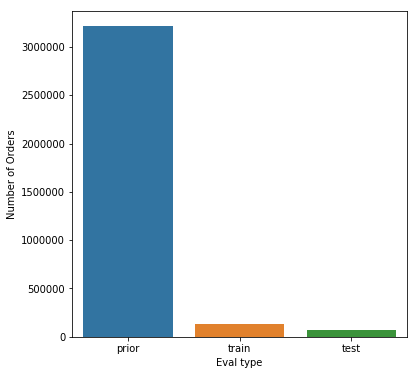

In [30]:
# plotting the above count
plt.figure(figsize=(6,6))
sns.barplot(orders_type.index, orders_type.values)
plt.xlabel('Eval type')
plt.ylabel('Number of Orders')
plt.show();

#### 2. At what time customers are making orders

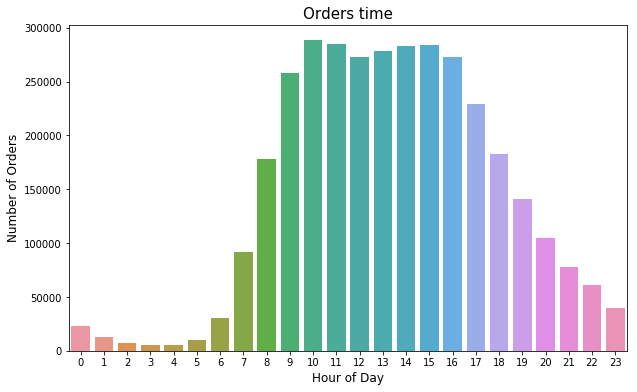

In [31]:
order_hour_count = df_orders['order_hour_of_day'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(order_hour_count.index, order_hour_count.values)
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Hour of Day', fontsize=12)
plt.title('Orders time', fontsize=15)
plt.show()

_Inference_: Looking at the graph it's clear that most orders were made during 7am to 8pm.

#### 3. On what day of a week customers are making orders

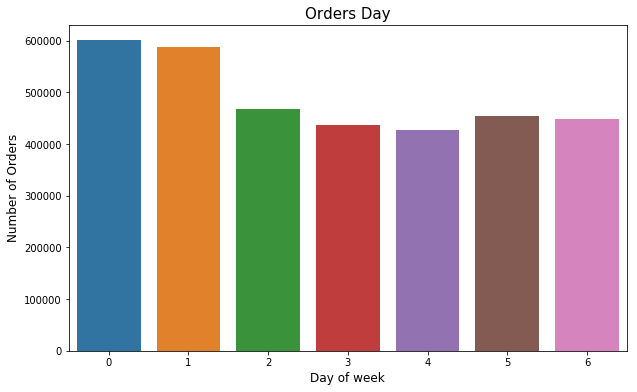

In [32]:
order_day = df_orders['order_dow'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(order_day.index, order_day.values)
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title('Orders Day', fontsize=15)
plt.show()

_Inference_: Assuming Week starts on Sunday (as no official comment being made on this), customers are buying relatively more on Sunday and Monday.

#### 4. Number of orders grouped by count

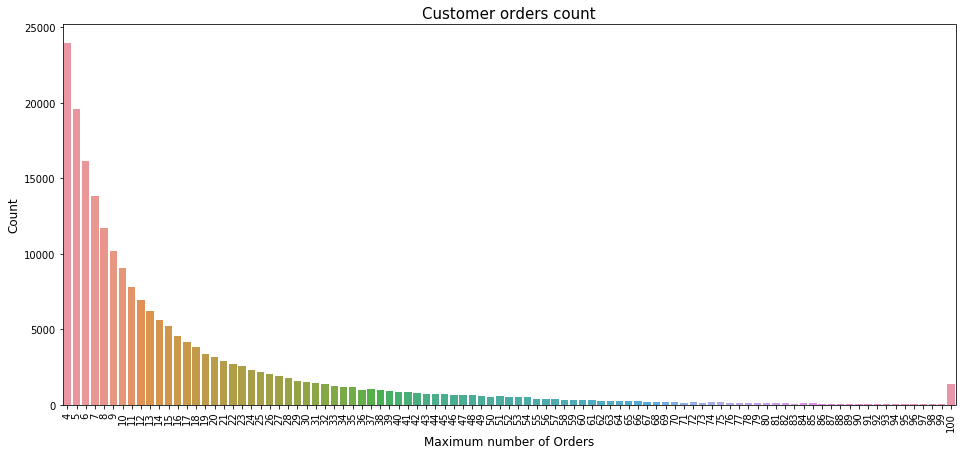

In [33]:
split_orders_count = df_orders.groupby('user_id')['order_number'].agg('max').reset_index()
split_orders_count = split_orders_count['order_number'].value_counts()

plt.figure(figsize=(16,7))
sns.barplot(split_orders_count.index, split_orders_count.values)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Maximum number of Orders', fontsize=12)
plt.title('Customer orders count', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Above plot indicates distribution orders count from all customers.

- 24,000 orders were by customers who had total order count 4
- 5,000 orders were by cutomers who had total order count 15

#### 5. When the next order is placed

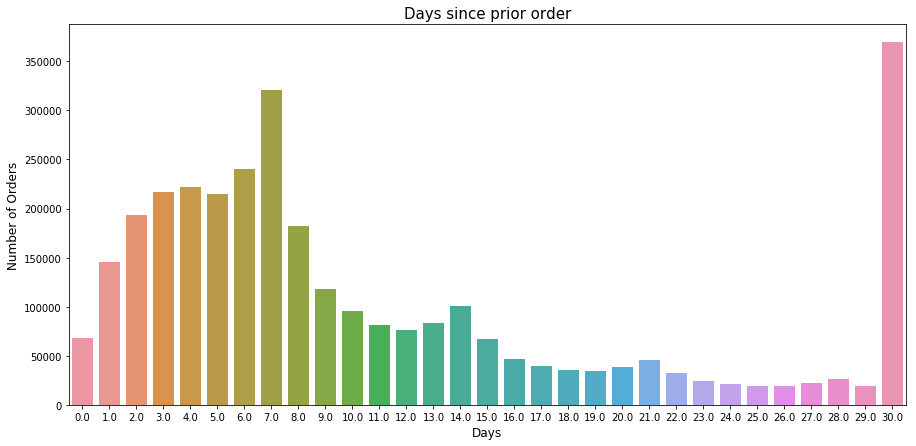

In [34]:
days_since_prior_order = df_orders['days_since_prior_order'].value_counts()

plt.figure(figsize=(15,7))
sns.barplot(days_since_prior_order.index, days_since_prior_order.values)
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Days', fontsize=12)
plt.title('Days since prior order', fontsize=15)
plt.show()

_Inference_: More customers are ordering again between day 1 - day 15 and on 30th day from their last order date.

#### 6. Percentage of products being reordered

In [35]:
# In order_products_prior
len(df_order_products_prior.query('reordered==1'))/df_order_products_prior.shape[0]

0.5896974667922161

In [36]:
# In order_proudcts_train
len(df_order_products_train.query('reordered==1'))/df_order_products_train.shape[0]

0.5985944127509629

Around 59% of products on each order being made are repeated products.

#### 7. Number of products in each order

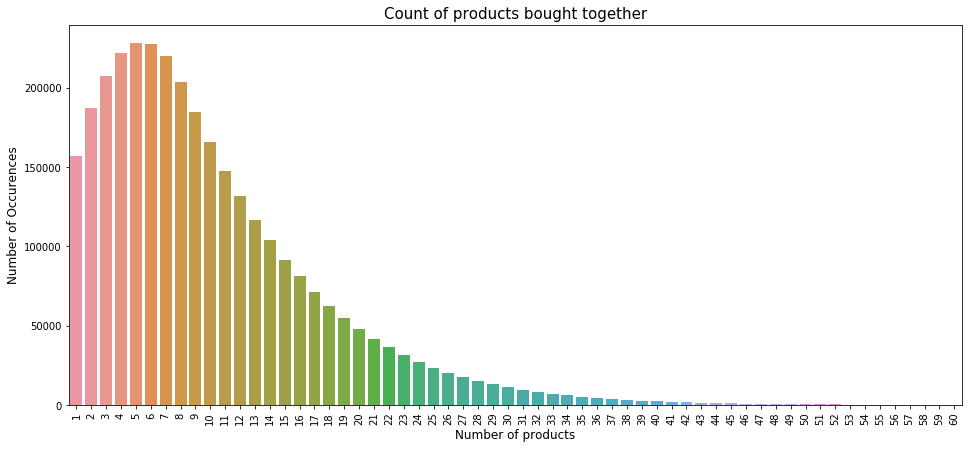

In [37]:
order_products_count = df_order_products_prior.groupby('order_id')['add_to_cart_order'].agg('max').reset_index()
order_products_cnt = order_products_count['add_to_cart_order'].value_counts().loc[lambda x : x>100] 

plt.figure(figsize=(16,7))
sns.barplot(order_products_cnt.index, order_products_cnt.values)
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Number of products', fontsize=12)
plt.title('Count of products bought together', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

It is observed in above graph that most orders have products between 1 and 20.

Ignoring orders which has total products count less than 100, this is just for convenience to view graph

In [38]:
order_products_count['add_to_cart_order'].value_counts().loc[lambda x : x<100].head()

62    79
63    67
64    57
65    53
66    49
Name: add_to_cart_order, dtype: int64

#### 8. Which products are bought more

In [39]:
products_prior = pd.merge(left=df_order_products_prior, right=df_orders, on='order_id')
products_prior = pd.merge(left=products_prior, right=df_products, on='product_id')

In [40]:
# user_products = pd.concat([products_prior, products_train])

print(products_prior.shape)
products_prior.head()

(32434489, 13)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16


In [41]:
common_products = products_prior['product_name'].value_counts().head(20)
common_products

Banana                      472565
Bag of Organic Bananas      379450
Organic Strawberries        264683
Organic Baby Spinach        241921
Organic Hass Avocado        213584
Organic Avocado             176815
Large Lemon                 152657
Strawberries                142951
Limes                       140627
Organic Whole Milk          137905
Organic Raspberries         137057
Organic Yellow Onion        113426
Organic Garlic              109778
Organic Zucchini            104823
Organic Blueberries         100060
Cucumber Kirby               97315
Organic Fuji Apple           89632
Organic Lemon                87746
Apple Honeycrisp Organic     85020
Organic Grape Tomatoes       84255
Name: product_name, dtype: int64

Interestingly Organic fruits are sold in large numbers.

#### 9. Which department selling more

In [42]:
products_prior = pd.merge(left=products_prior, right=df_departments, on='department_id')
products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,dairy eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,dairy eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,dairy eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,dairy eggs


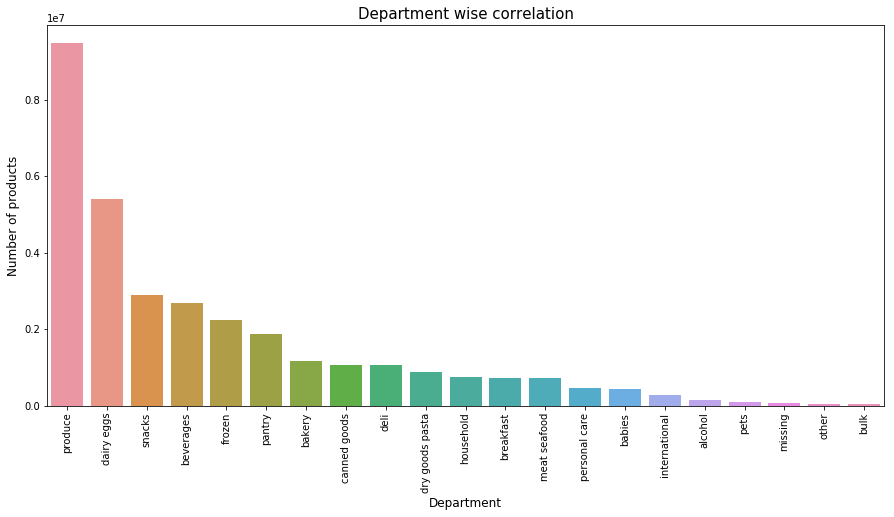

In [43]:
department_orders = products_prior['department'].value_counts()

plt.figure(figsize=(15,7))
sns.barplot(department_orders.index, department_orders.values)
plt.ylabel('Number of products', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title('Department wise correlation', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [44]:
department_orders

produce            9479291
dairy eggs         5414016
snacks             2887550
beverages          2690129
frozen             2236432
pantry             1875577
bakery             1176787
canned goods       1068058
deli               1051249
dry goods pasta     866627
household           738666
breakfast           709569
meat seafood        708931
personal care       447123
babies              423802
international       269253
alcohol             153696
pets                 97724
missing              69145
other                36291
bulk                 34573
Name: department, dtype: int64

I realised dataset provided cannot be used in it's raw form so we will delete above dataframes to free up memory and then perform feature engineering in next step.

In [45]:
del df_aisles
del df_departments
del df_products
del df_order_products_prior
del df_order_products_train
del df_orders

In [46]:
del orders_type
del order_hour_count
del order_day
del split_orders_count
del days_since_prior_order
del order_products_count
del order_products_cnt
del common_products
del products_prior
del department_orders

### Benchmark

Since the problem statement is taken from kaggle competition, we will use the Leaderboard and the winners score as benchmark.

F-Score of 0.40972 on Public Leaderboard is observed as best score for the above said problem statement.

Ref: https://www.kaggle.com/c/instacart-market-basket-analysis/leaderboard

## Methodology <a id="methodology"></a>

We want to predict products in next order, in order to do that We have to have create feature set for training along with label.

We are ignoring aisle as it doesn't influence customer buying habit.

In [47]:
priorOrderItems = pd.read_csv('dataset/order_products__prior.csv')
trainingOrderItems = pd.read_csv('dataset/order_products__train.csv')
orders = pd.read_csv('dataset/orders.csv')
products = pd.read_csv('dataset/products.csv')

#### Basket Size

since *add_to_cart_order* holds count of product number in each order, we can extract basket size by aggregating with max.

In [48]:
orderGroup = priorOrderItems.groupby('order_id')['add_to_cart_order'].agg('max').reset_index(name='basket_size')
priorOrderItems = pd.merge(priorOrderItems, orderGroup, on='order_id')

del orderGroup
print(priorOrderItems.shape)
priorOrderItems.head()

(32434489, 5)


,order_id,product_id,add_to_cart_order,reordered,basket_size
0,2,33120,1,1,9
1,2,28985,2,1,9
2,2,9327,3,0,9
3,2,45918,4,1,9
4,2,30035,5,0,9


#### Extracting information from products ordered by customer

In [49]:
orderItems = pd.merge(orders, priorOrderItems, on='order_id')
orderItems['user_product_id'] = 1000000 * orderItems['user_id'] + orderItems['product_id']

print(orderItems.shape)
orderItems.head()

(32434489, 12)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,basket_size,user_product_id
0,2539329,1,prior,1,2,8,NaN,196,1,0,5,1000196
1,2539329,1,prior,1,2,8,NaN,14084,2,0,5,1014084
2,2539329,1,prior,1,2,8,NaN,12427,3,0,5,1012427
3,2539329,1,prior,1,2,8,NaN,26088,4,0,5,1026088
4,2539329,1,prior,1,2,8,NaN,26405,5,0,5,1026405


In [50]:
userProducts = orderItems.query('eval_set == "prior"')
userProducts = userProducts[['user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
                             'product_id', 'add_to_cart_order', 'user_product_id', 'basket_size', 
                             'order_number', 'order_id']]
# we will update this count next
userProducts['user_product_orders'] = userProducts['user_id']

print(userProducts.shape)
userProducts.head()

(32434489, 11)


,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,user_product_id,basket_size,order_number,order_id,user_product_orders
0,1,2,8,NaN,196,1,1000196,5,1,2539329,1
1,1,2,8,NaN,14084,2,1014084,5,1,2539329,1
2,1,2,8,NaN,12427,3,1012427,5,1,2539329,1
3,1,2,8,NaN,26088,4,1026088,5,1,2539329,1
4,1,2,8,NaN,26405,5,1026405,5,1,2539329,1


In [51]:
# finding mean
userAvgProducts = userProducts.groupby('user_product_id').aggregate({'user_id':'mean',
                                                                     'order_dow':'mean',
                                                                     'order_hour_of_day':'mean',
                                                                     'days_since_prior_order':'mean',
                                                                     'user_product_orders':'count',
                                                                     'product_id':'mean',
                                                                     'basket_size':'mean'})
del orderItems
print(userAvgProducts.shape)
userAvgProducts.head()

(13307953, 7)


,user_id,order_dow,order_hour_of_day,days_since_prior_order,user_product_orders,product_id,basket_size
user_product_id,,,,,,,
1000196,1,2.500000,10.300000,19.555556,10,196,5.900000
1010258,1,2.555556,10.555556,19.555556,9,10258,6.000000
1010326,1,4.000000,15.000000,28.000000,1,10326,8.000000
1012427,1,2.500000,10.300000,19.555556,10,12427,5.900000
1013032,1,2.666667,8.000000,21.666667,3,13032,6.666667


user_product_orders includes both repeated (> 1) and non-repeated products (==1).

In [52]:
# To verify that total products count is same as sum of repeated and non-repeated products count.
userAvgProducts['user_product_orders'].agg('sum')

32434489

In [53]:
user_distinct_products = userAvgProducts.groupby('user_id').count()['product_id'].to_frame()
user_distinct_products['user_reordered_products'] = userAvgProducts[userAvgProducts['user_product_orders']>1].groupby('user_id').count()['product_id']
user_distinct_products.rename(columns={'product_id':'distinct_products'},inplace=True)

print(user_distinct_products.shape)
user_distinct_products.head()

(206209, 2)


,distinct_products,user_reordered_products
user_id,,
1,18,10.0
2,102,37.0
3,33,19.0
4,17,1.0
5,23,8.0


In [54]:
userAvgProducts = pd.merge(user_distinct_products, userAvgProducts, left_index=True, right_on='user_id')
print(userAvgProducts.shape)
userAvgProducts.head()

(13307953, 9)


,distinct_products,user_reordered_products,user_id,order_dow,order_hour_of_day,days_since_prior_order,user_product_orders,product_id,basket_size
user_product_id,,,,,,,,,
1000196,18,10.0,1,2.500000,10.300000,19.555556,10,196,5.900000
1010258,18,10.0,1,2.555556,10.555556,19.555556,9,10258,6.000000
1010326,18,10.0,1,4.000000,15.000000,28.000000,1,10326,8.000000
1012427,18,10.0,1,2.500000,10.300000,19.555556,10,12427,5.900000
1013032,18,10.0,1,2.666667,8.000000,21.666667,3,13032,6.666667


In [55]:
userAvgProducts['user_reorder_rate'] = userAvgProducts['user_reordered_products']/userAvgProducts['distinct_products']
userAvgProducts.head()

,distinct_products,user_reordered_products,user_id,order_dow,order_hour_of_day,days_since_prior_order,user_product_orders,product_id,basket_size,user_reorder_rate
user_product_id,,,,,,,,,,
1000196,18,10.0,1,2.500000,10.300000,19.555556,10,196,5.900000,0.555556
1010258,18,10.0,1,2.555556,10.555556,19.555556,9,10258,6.000000,0.555556
1010326,18,10.0,1,4.000000,15.000000,28.000000,1,10326,8.000000,0.555556
1012427,18,10.0,1,2.500000,10.300000,19.555556,10,12427,5.900000,0.555556
1013032,18,10.0,1,2.666667,8.000000,21.666667,3,13032,6.666667,0.555556


In [56]:
features = userAvgProducts
features.columns = ['user_distinct_products','user_reordered_products','user_id','user_product_dow','user_product_hod','user_product_dsp','user_product_orders','product_id', 'user_avg_basket_size','user_reorder_rate']


In [57]:
userOrders = orders.query('eval_set == "prior"').groupby('user_id').aggregate('max')
print(userOrders.shape)
userOrders.head()

(206209, 6)


,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
user_id,,,,,,
1,3367565,prior,10,4,16,30.0
2,3268552,prior,14,5,15,30.0
3,3225766,prior,12,3,19,21.0
4,3343014,prior,5,6,15,21.0
5,2717275,prior,4,3,18,19.0


In [58]:
userOrders = userOrders[['order_number']]
features = pd.merge(userOrders, features, right_on='user_id', left_index=True)
features['order_number'] = features['user_product_orders']/features['order_number']
features.rename(columns={'order_number': 'user_product_reorder_rate'}, inplace=True)

print(features.shape)
features.head()

(13307953, 11)


,user_product_reorder_rate,user_distinct_products,user_reordered_products,user_id,user_product_dow,user_product_hod,user_product_dsp,user_product_orders,product_id,user_avg_basket_size,user_reorder_rate
user_product_id,,,,,,,,,,,
1000196,1.0,18,10.0,1,2.500000,10.300000,19.555556,10,196,5.900000,0.555556
1010258,0.9,18,10.0,1,2.555556,10.555556,19.555556,9,10258,6.000000,0.555556
1010326,0.1,18,10.0,1,4.000000,15.000000,28.000000,1,10326,8.000000,0.555556
1012427,1.0,18,10.0,1,2.500000,10.300000,19.555556,10,12427,5.900000,0.555556
1013032,0.3,18,10.0,1,2.666667,8.000000,21.666667,3,13032,6.666667,0.555556


In [59]:
features = pd.merge(features, products, on='product_id')
features.drop('product_name', axis=1, inplace=True)

print(features.shape)
features.head()

(13307953, 13)


,user_product_reorder_rate,user_distinct_products,user_reordered_products,user_id,user_product_dow,user_product_hod,user_product_dsp,user_product_orders,product_id,user_avg_basket_size,user_reorder_rate,aisle_id,department_id
0,1.000000,18,10.0,1,2.5,10.300000,19.555556,10,196,5.900000,0.555556,77,7
1,0.227273,13,9.0,15,1.4,11.000000,8.600000,5,196,2.800000,0.692308,77,7
2,0.333333,133,39.0,19,5.0,14.333333,6.666667,3,196,31.333333,0.293233,77,7
3,0.030303,102,30.0,21,3.0,10.000000,6.000000,1,196,7.000000,0.294118,77,7
4,0.100000,190,66.0,31,3.0,9.500000,7.500000,2,196,27.500000,0.347368,77,7


In [60]:
user_order_group = orders[orders['eval_set']=='prior'].groupby('user_id').aggregate({'order_id':'count', 'days_since_prior_order':'mean'})
user_order_group.rename(columns={'order_id':'user_orders','days_since_prior_order':'user_order_dsp'},inplace=True)
print(user_order_group.shape)
user_order_group.head()


(206209, 2)


,user_orders,user_order_dsp
user_id,,
1,10,19.555556
2,14,15.230769
3,12,12.090909
4,5,13.750000
5,4,13.333333


In [61]:
features = pd.merge(features, user_order_group, left_on='user_id', right_index=True)
print(features.shape)
features.head()

(13307953, 15)


,user_product_reorder_rate,user_distinct_products,user_reordered_products,user_id,user_product_dow,user_product_hod,user_product_dsp,user_product_orders,product_id,user_avg_basket_size,user_reorder_rate,aisle_id,department_id,user_orders,user_order_dsp
0,1.0,18,10.0,1,2.500000,10.300000,19.555556,10,196,5.900000,0.555556,77,7,10,19.555556
8000,0.9,18,10.0,1,2.555556,10.555556,19.555556,9,10258,6.000000,0.555556,117,19,10,19.555556
8557,0.1,18,10.0,1,4.000000,15.000000,28.000000,1,10326,8.000000,0.555556,24,4,10,19.555556
10480,1.0,18,10.0,1,2.500000,10.300000,19.555556,10,12427,5.900000,0.555556,23,19,10,19.555556
12159,0.3,18,10.0,1,2.666667,8.000000,21.666667,3,13032,6.666667,0.555556,121,14,10,19.555556


In [62]:
features['user_total_products'] = features['user_avg_basket_size']*features['user_orders']
features.head()

,user_product_reorder_rate,user_distinct_products,user_reordered_products,user_id,user_product_dow,user_product_hod,user_product_dsp,user_product_orders,product_id,user_avg_basket_size,user_reorder_rate,aisle_id,department_id,user_orders,user_order_dsp,user_total_products
0,1.0,18,10.0,1,2.500000,10.300000,19.555556,10,196,5.900000,0.555556,77,7,10,19.555556,59.000000
8000,0.9,18,10.0,1,2.555556,10.555556,19.555556,9,10258,6.000000,0.555556,117,19,10,19.555556,60.000000
8557,0.1,18,10.0,1,4.000000,15.000000,28.000000,1,10326,8.000000,0.555556,24,4,10,19.555556,80.000000
10480,1.0,18,10.0,1,2.500000,10.300000,19.555556,10,12427,5.900000,0.555556,23,19,10,19.555556,59.000000
12159,0.3,18,10.0,1,2.666667,8.000000,21.666667,3,13032,6.666667,0.555556,121,14,10,19.555556,66.666667


In [63]:
train_orders = orders.query('eval_set == "train"')
test_orders = orders.query('eval_set == "test"')

In [64]:
train_features = pd.merge(train_orders, features, on='user_id')
test_features = pd.merge(test_orders, features, on='user_id')

In [65]:
del train_orders
del test_orders
del features

In [66]:
train_features.sort_values(['order_id','product_id'], inplace=True)
test_features.sort_values(['order_id','product_id'], inplace=True)

In [67]:
print(train_features.shape)
train_features.head()

(8474661, 22)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product_reorder_rate,user_distinct_products,user_reordered_products,...,user_product_dsp,user_product_orders,product_id,user_avg_basket_size,user_reorder_rate,aisle_id,department_id,user_orders,user_order_dsp,user_total_products
4629306,1,112108,train,4,4,10,9.0,0.333333,12,8.0,...,7.0,1,2067,8.0,0.666667,3,19,3,11.0,24.0
4629308,1,112108,train,4,4,10,9.0,0.666667,12,8.0,...,11.0,2,5707,6.5,0.666667,3,19,3,11.0,19.5
4629307,1,112108,train,4,4,10,9.0,0.666667,12,8.0,...,7.0,2,11109,8.0,0.666667,108,16,3,11.0,24.0
4629304,1,112108,train,4,4,10,9.0,1.000000,12,8.0,...,11.0,3,14947,7.0,0.666667,115,7,3,11.0,21.0
4629302,1,112108,train,4,4,10,9.0,0.666667,12,8.0,...,7.0,2,22035,8.0,0.666667,21,16,3,11.0,24.0


In [68]:
print(test_features.shape)
test_features.head()

(4833292, 22)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product_reorder_rate,user_distinct_products,user_reordered_products,...,user_product_dsp,user_product_orders,product_id,user_avg_basket_size,user_reorder_rate,aisle_id,department_id,user_orders,user_order_dsp,user_total_products
858095,17,36855,test,5,6,15,1.0,0.25,21,5.0,...,30.0,1,1283,9.000000,0.238095,100,21,4,14.0,36.000000
858092,17,36855,test,5,6,15,1.0,0.25,21,5.0,...,6.0,1,6291,9.000000,0.238095,121,14,4,14.0,36.000000
858088,17,36855,test,5,6,15,1.0,0.25,21,5.0,...,NaN,1,7035,5.000000,0.238095,100,21,4,14.0,20.000000
858094,17,36855,test,5,6,15,1.0,0.25,21,5.0,...,NaN,1,11494,5.000000,0.238095,100,21,4,14.0,20.000000
858097,17,36855,test,5,6,15,1.0,0.75,21,5.0,...,14.0,3,13107,7.333333,0.238095,3,19,4,14.0,29.333333


In [69]:
train_features.drop(['eval_set','order_number'], axis=1, inplace=True)
test_features.drop(['eval_set','order_number'], axis=1, inplace=True)

### Making training labels

In [70]:
train_orders = orders[orders['eval_set']=='train']
trainProducts = pd.merge(train_orders, trainingOrderItems, on='order_id')
print(trainProducts.shape)
trainProducts.head()

(1384617, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,1187899,1,train,11,4,8,14.0,196,1,1
1,1187899,1,train,11,4,8,14.0,25133,2,1
2,1187899,1,train,11,4,8,14.0,38928,3,1
3,1187899,1,train,11,4,8,14.0,26405,4,1
4,1187899,1,train,11,4,8,14.0,39657,5,1


In [71]:
trainProducts = trainProducts.groupby('user_id')['product_id'].apply(set)
trainProducts.head()

user_id
1    {196, 26405, 27845, 46149, 13032, 39657, 26088...
2    {24838, 11913, 45066, 31883, 48523, 38547, 248...
5    {40706, 21413, 20843, 48204, 21616, 19057, 201...
7    {17638, 29894, 47272, 45066, 13198, 37999, 408...
8    {27104, 15937, 5539, 41540, 31717, 48230, 2224...
Name: product_id, dtype: object

In [72]:
from tqdm import tqdm

trainLabels = []
for row in tqdm(train_features.itertuples()):
    trainLabels += [row.product_id in trainProducts[row.user_id]]
    
print(train_features.shape)

8474661it [03:28, 40660.89it/s]

(8474661, 20)


In [73]:
train_features.columns

Index(['order_id', 'user_id', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'user_product_reorder_rate',
       'user_distinct_products', 'user_reordered_products', 'user_product_dow',
       'user_product_hod', 'user_product_dsp', 'user_product_orders',
       'product_id', 'user_avg_basket_size', 'user_reorder_rate', 'aisle_id',
       'department_id', 'user_orders', 'user_order_dsp',
       'user_total_products'],
      dtype='object')

### Scaling the data using Min-Max Normalization

In [74]:
feature_list=['user_avg_basket_size','days_since_prior_order','user_product_reorder_rate','user_product_dow',
              'user_reordered_products','user_product_hod','user_product_dsp','user_product_orders',
              'user_reorder_rate','user_distinct_products']

train_features[feature_list] = (train_features[feature_list]-train_features[feature_list].mean())/((train_features[feature_list].max()-train_features[feature_list].min()))
test_features[feature_list] = (test_features[feature_list]-test_features[feature_list].mean())/((test_features[feature_list].max()-test_features[feature_list].min()))

In [75]:
print(train_features.shape)
train_features[feature_list].head()

(8474661, 20)


,user_avg_basket_size,days_since_prior_order,user_product_reorder_rate,user_product_dow,user_reordered_products,user_product_hod,user_product_dsp,user_product_orders,user_reorder_rate,user_distinct_products
4629306,-0.052874,-0.178176,0.181188,-0.292511,-0.098748,-0.153366,-0.189770,-0.014650,0.268539,-0.140862
4629308,-0.063290,-0.178176,0.517923,-0.209177,-0.098748,0.085764,-0.056437,-0.004446,0.268539,-0.140862
4629307,-0.052874,-0.178176,0.517923,-0.292511,-0.098748,-0.066409,-0.189770,-0.004446,0.268539,-0.140862
4629304,-0.059818,-0.178176,0.854658,-0.236955,-0.098748,0.064025,-0.056437,0.005758,0.268539,-0.140862
4629302,-0.052874,-0.178176,0.517923,-0.292511,-0.098748,-0.066409,-0.189770,-0.004446,0.268539,-0.140862


In [76]:
print(test_features.shape)
test_features[feature_list].head()

(4833292, 20)


,user_avg_basket_size,days_since_prior_order,user_product_reorder_rate,user_product_dow,user_reordered_products,user_product_hod,user_product_dsp,user_product_orders,user_reorder_rate,user_distinct_products
858095,-0.061448,-0.446237,0.096375,-0.458892,-0.14103,-0.196971,0.576189,-0.014692,-0.16614,-0.145215
858092,-0.061448,-0.446237,0.096375,0.541108,-0.14103,0.020420,-0.223811,-0.014692,-0.16614,-0.145215
858088,-0.098485,-0.446237,0.096375,-0.292225,-0.14103,-0.023058,NaN,-0.014692,-0.16614,-0.145215
858094,-0.098485,-0.446237,0.096375,-0.292225,-0.14103,-0.023058,NaN,-0.014692,-0.16614,-0.145215
858097,-0.076880,-0.446237,0.601477,0.152219,-0.14103,-0.066536,0.042856,0.005716,-0.16614,-0.145215


In [77]:
X_train = train_features[feature_list].fillna(0).values[:500000]
Y_train = np.array(trainLabels).astype('int8')[:500000]

print (X_train[:5])
print(Y_train[:5])

[[-0.05287379 -0.17817632  0.1811884  -0.29251074 -0.09874768 -0.15336596
  -0.18977016 -0.01465031  0.26853874 -0.14086191]
 [-0.06329045 -0.17817632  0.51792309 -0.20917741 -0.09874768  0.08576447
  -0.05643682 -0.00444623  0.26853874 -0.14086191]
 [-0.05287379 -0.17817632  0.51792309 -0.29251074 -0.09874768 -0.06640944
  -0.18977016 -0.00444623  0.26853874 -0.14086191]
 [-0.05981823 -0.17817632  0.85465778 -0.23695518 -0.09874768  0.06402534
  -0.05643682  0.00575785  0.26853874 -0.14086191]
 [-0.05287379 -0.17817632  0.51792309 -0.29251074 -0.09874768 -0.06640944
  -0.18977016 -0.00444623  0.26853874 -0.14086191]]
[0 0 1 0 1]


## Results <a id="results"></a>

### Defining the model architecture

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from keras_tqdm import TQDMNotebookCallback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [79]:
np.random.seed(9)

model = Sequential()
model.add(Dense(10, input_dim=len(feature_list), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# define the checkpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

#### Training and Evaluate

In [80]:
# fit the model
model.fit(X_train, Y_train, epochs=10, callbacks=callbacks_list)

scores = model.evaluate(X_train, Y_train, verbose=0)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

W0901 15:18:46.325304 4494882240 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 500000 samples
Epoch 1/10
499904/500000 [============================>.] - ETA: 0s - loss: 0.2680 - accuracy: 0.9070
Epoch 00001: loss improved from inf to 0.26802, saving model to model.h5
500000/500000 [==============================] - 43s 86us/sample - loss: 0.2680 - accuracy: 0.9070
Epoch 2/10
499616/500000 [============================>.] - ETA: 0s - loss: 0.2652 - accuracy: 0.9074
Epoch 00002: loss improved from 0.26802 to 0.26513, saving model to model.h5
500000/500000 [==============================] - 41s 82us/sample - loss: 0.2651 - accuracy: 0.9074
Epoch 3/10
499456/500000 [============================>.] - ETA: 0s - loss: 0.2645 - accuracy: 0.9077
Epoch 00003: loss improved from 0.26513 to 0.26449, saving model to model.h5
500000/500000 [==============================] - 41s 83us/sample - loss: 0.2645 - accuracy: 0.9077
Epoch 4/10
499616/500000 [============================>.] - ETA: 0s - loss: 0.2641 - accuracy: 0.9077
Epoch 00004: loss improved from 0.26449 to 0

### Training dataset lables

In [81]:
X_test_trained = train_features[feature_list].fillna(0).values[500000:1000000]
Y_test_trained = np.array(trainLabels).astype('int8')[500000:1000000]

trained_preds = model.predict(X_test_trained)
print(trained_preds.shape)
# saving the result
output = {}
i = 0
for row in train_features[500000:1000000].itertuples():
    if row.order_id in output.keys():
        if (trained_preds[i]>.2):
            temp = output.get(row.order_id, [])
            temp.append(row.product_id)
            output[row.order_id] = temp
    else:
        if (trained_preds[i]>.2):
            output[row.order_id] = [row.product_id]
    i+=1

with open('trained_prediction.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in output.items():
       writer.writerow([key, value])

(500000, 1)


### F-Score

In [82]:
truePositive = 0
falsePositive = 0
falseNegative=0
trueNegative=0

def f_score(truePositive, falseNegative, falsePositive, beta=1):
    return ((1+beta**2)*truePositive)/(((1+beta**2)*truePositive)+beta**2*falseNegative+falsePositive)

for i in range(len(trained_preds)):
    if trained_preds[i] > .2:
        if (Y_test_trained)[i] == 1:
            truePositive +=1
        else:
            falsePositive+=1
    else:
        if (Y_test_trained)[i] == 1:
            falseNegative+=1
        else:
            trueNegative+=1

print(truePositive, trueNegative, falsePositive, falseNegative)
print(f_score(truePositive, falseNegative, falsePositive))

19961 417496 33819 28724
0.38961596642756063


### Prediction for our test dataset

In [83]:
X_test = test_features[feature_list].fillna(0).values

test_preds = model.predict(X_test)
test_preds

array([[0.20823574],
       [0.075091  ],
       [0.0955148 ],
       ...,
       [0.08333373],
       [0.13769962],
       [0.08333373]], dtype=float32)

In [84]:
test_preds.shape

(4833292, 1)

#### Saving the result

In [85]:
output = {}
i = 0
for row in test_features.itertuples():
    if row.order_id in output.keys():
        if (test_preds[i]>.2):
            temp = output.get(row.order_id, [])
            temp.append(row.product_id)
            output[row.order_id] = temp
    else:
        if (test_preds[i]>.2):
            output[row.order_id] = [row.product_id]
    i+=1

In [86]:
with open('prediction.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in output.items():
       writer.writerow([key, value])

### Justification

F-Score of our model is **0.38838** and F-Score of benchmark model is **0.40972**. So we can confidently say our final model and solution is significant enough to have adequately solved the problem.

## Conclusion <a id="conclusion"></a>

### Reflection

After doing initial data exploration I was stuck how data provided can be used to make prediction, then came across feature extraction which is a must for this project to provide right input data for model and create training-labels out of those extracted data.

### Improvement

We could improve performance of our model by extracting more complex correlated features and using algorithms such as XGBoost.